In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
! pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from numpy import sort, loadtxt

In [ ]:
#snippet to load the grouth truth training labels and normalize the label predictions. 
#your trained model will predict in this space (0 to 10)
df_y = pd.read_csv('gdrive/MyDrive/CS4220/Datasets/labels.csv', index_col=0)
le = preprocessing.LabelEncoder()
le.fit(df_y['genome_name'].unique())
le.classes_

array(['burkholderia_pseudomallei', 'corynebacterium_diphtheriae',
       'corynebacterium_ulcerans', 'decoy', 'mycobacterium_tuberculosis',
       'mycobacterium_ulcerans', 'neisseria_gonorrhoeae',
       'pseudomonas_aeruginosa', 'staphylococcus_aureus',
       'staphylococcus_pyogenes', 'streptococcus_pneumoniae'],
      dtype=object)

In [ ]:
df = pd.read_csv('gdrive/MyDrive/CS4220/Datasets/training-decoy-90.csv.gz')

In [ ]:
df

,1517,1934,326,2069,730,63,2001,1166,311,1504,...,1958,359,164,1853,910,882,1447,1544,1089,genome_label
0,0.004177,0.000144,0.000288,0.009507,0.000000,0.000288,0.002449,0.000144,0.000288,0.000720,...,0.001008,0.000288,0.000000,0.002161,0.000288,0.000720,0.000432,0.001008,0.000144,0
1,0.009114,0.000829,0.000000,0.003314,0.000000,0.000000,0.000829,0.000000,0.000000,0.000829,...,0.000829,0.000000,0.000829,0.000000,0.000000,0.000829,0.000000,0.002485,0.000000,0
2,0.014228,0.000000,0.000000,0.020325,0.000000,0.002033,0.002033,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002033,0.000000,0.000000,0
3,0.002988,0.000498,0.000125,0.003735,0.000249,0.000747,0.000747,0.000996,0.000374,0.000249,...,0.000249,0.000249,0.000747,0.001494,0.000000,0.000872,0.000498,0.000623,0.000374,0
4,0.004320,0.000152,0.000152,0.006670,0.000000,0.000682,0.000985,0.000455,0.000152,0.000758,...,0.000682,0.000076,0.000455,0.001440,0.000076,0.000227,0.000606,0.000910,0.000455,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87181,0.000000,0.000000,0.004115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
87182,0.000123,0.001232,0.000616,0.000000,0.001109,0.000000,0.000000,0.000616,0.001724,0.000000,...,0.000493,0.001355,0.000616,0.000493,0.000370,0.000000,0.000246,0.000246,0.000000,3
87183,0.000353,0.001060,0.000706,0.000000,0.000706,0.000000,0.000000,0.001060,0.001413,0.000000,...,0.000000,0.001060,0.000353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
87184,0.000000,0.000000,0.007653,0.000000,0.000000,0.000000,0.000000,0.000000,0.005102,0.000000,...,0.000000,0.002551,0.000000,0.000000,0.001276,0.000000,0.000000,0.000000,0.000000,3


In [ ]:
df['genome_label'].value_counts()

3     78459
0      1669
7      1476
5      1323
4      1027
8       665
2       578
1       563
6       514
10      507
9       405
Name: genome_label, dtype: int64

In [ ]:
df['genome_label'] = pd.Categorical(df['genome_label'])

In [ ]:
print(df.dtypes)

In [ ]:
#separate target variable from other variables 
X, y = df.iloc[:, :-1], df.iloc[:, -1]

#convert into dmatrix format for xgboost
df_dmatrix = xgb.DMatrix(data=X, label=y)

In [ ]:
#train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [ ]:
#build default xgboost classifier
model = XGBClassifier(objective='multi:softmax', num_class=11, 
                      tree_method = 'auto',   
                      n_estimators = 200, max_depth = 4, 
                      reg_lambda=0, reg_alpha=1.0, 
                      base_score=0,
                      seed=123)
model._le = le

#define eval set & metric 
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ['mlogloss', 'merror'] 

#fit model
model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric= eval_metric, eval_set=eval_set) 

[0]	validation_0-mlogloss:1.93534	validation_0-merror:0.067658	validation_1-mlogloss:1.93732	validation_1-merror:0.070019
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.65487	validation_0-merror:0.066454	validation_1-mlogloss:1.6592	validation_1-merror:0.068987
[2]	validation_0-mlogloss:1.45185	validation_0-merror:0.065608	validation_1-mlogloss:1.45769	validation_1-merror:0.06893
[3]	validation_0-mlogloss:1.29244	validation_0-merror:0.065249	validation_1-mlogloss:1.2993	validation_1-merror:0.06807
[4]	validation_0-mlogloss:1.16125	validation_0-merror:0.064489	validation_1-mlogloss:1.16925	validation_1-merror:0.067496
[5]	validation_0-mlogloss:1.05124	validation_0-merror:0.063715	validation_1-mlogloss:1.06074	validation_1-merror:0.06698
[6]	validation_0-mlogloss:0.957215	validation_0-merror:0.063314	validation_1-mlogloss:0.968311	validation_1-me

XGBClassifier(base_score=0, max_depth=4, n_estimators=200, num_class=11,
              objective='multi:softprob', reg_alpha=1.0, reg_lambda=0, seed=123,
              tree_method='auto')

In [ ]:
# preliminary model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.991297241497964
Test Accuraccy:  0.959800435829797
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       334
           1       0.97      0.58      0.73       113
           2       0.99      0.58      0.73       116
           3       0.96      1.00      0.98     15692
           4       0.72      0.56      0.63       205
           5       0.79      0.64      0.71       265
           6       0.90      0.09      0.16       103
           7       0.98      0.82      0.89       295
           8       0.92      0.09      0.16       133
           9       0.95      0.44      0.61        81
          10       0.91      0.42      0.57       101

    accuracy                           0.96     17438
   macro avg       0.92      0.56      0.65     17438
weighted avg       0.96      0.96      0.95     17438



In [ ]:
import joblib
from joblib import dump, load
#save model
joblib.dump(model, 'xgb-d90-tuned.joblib') 

['xgb-d90-tuned.joblib']

Performance Metrics

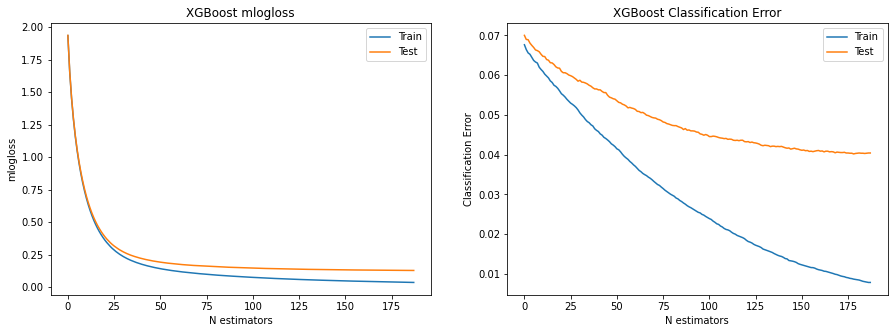

<Figure size 432x288 with 0 Axes>

In [ ]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot auc
ax[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost mlogloss')
ax[0].set_ylabel('mlogloss')
ax[0].set_xlabel('N estimators')

# plot classification error
ax[1].plot(x_axis, results['validation_0']['merror'], label='Train')
ax[1].plot(x_axis, results['validation_1']['merror'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

# Feature Selection

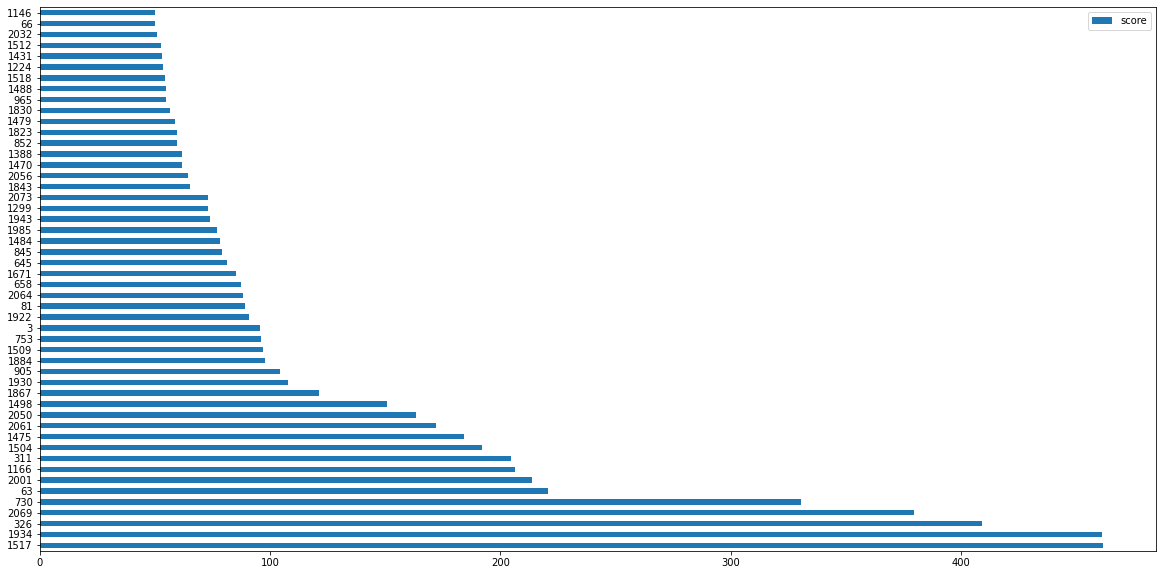

In [ ]:
#retrieve feature importance for every column
features = model.get_booster().get_score(importance_type='gain')
keys = list(features.keys())
values = list(features.values())

#store feature importance score in dataframe & plot top 50
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(50, columns="score").plot(kind='barh', figsize = (20,10)) 

In [ ]:
data.nlargest(416, columns = 'score')

,score
1517,461.482757
1934,461.062844
326,409.021498
2069,379.510616
730,330.687972
...,...
1611,15.281754
2015,15.195017
1570,15.175966
21,15.125039


In [ ]:
#list of top 20% features 
feature_list = list(data.head(520).index.values)
feature_list.append('genome_label')

#new dataframe of extracted features 
ex = df.reindex(columns = feature_list)
ex['genome_label'] = pd.Categorical(ex['genome_label'])

In [ ]:
import json
#export feature list of top 20% features 
with open('top-25-stratified.txt', 'w') as f:
    f.write(json.dumps(feature_list))

In [ ]:
#separate target variable from other variables 
X, y = ex.iloc[:, :-1], ex.iloc[:, -1]

#convert into dmatrix format for xgboost
df_dmatrix = xgb.DMatrix(data=X, label=y)

#train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#build default xgboost classifier
model = XGBClassifier(objective='multi:softmax', num_class=11, 
                      tree_method = 'gpu_hist', 
                      n_estimators = 400, 
                      seed=123)

#define eval set & metric 
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ['mlogloss', 'merror'] 

#fit model
model.fit(X_train, y_train, verbose=True, eval_metric= eval_metric, eval_set=eval_set) 

[0]	validation_0-mlogloss:2.12538	validation_0-merror:0.297294	validation_1-mlogloss:2.13176	validation_1-merror:0.326087
[1]	validation_0-mlogloss:1.93826	validation_0-merror:0.269762	validation_1-mlogloss:1.95049	validation_1-merror:0.302457
[2]	validation_0-mlogloss:1.79278	validation_0-merror:0.250502	validation_1-mlogloss:1.80964	validation_1-merror:0.284972
[3]	validation_0-mlogloss:1.67179	validation_0-merror:0.241935	validation_1-mlogloss:1.69243	validation_1-merror:0.270558
[4]	validation_0-mlogloss:1.56866	validation_0-merror:0.231183	validation_1-mlogloss:1.59328	validation_1-merror:0.258979
[5]	validation_0-mlogloss:1.47917	validation_0-merror:0.219957	validation_1-mlogloss:1.50626	validation_1-merror:0.252836
[6]	validation_0-mlogloss:1.40102	validation_0-merror:0.214168	validation_1-mlogloss:1.43168	validation_1-merror:0.246456
[7]	validation_0-mlogloss:1.33101	validation_0-merror:0.210209	validation_1-mlogloss:1.36368	validation_1-merror:0.242202
[8]	validation_0-mloglos

XGBClassifier(n_estimators=400, num_class=11, objective='multi:softprob',
              seed=123, tree_method='gpu_hist')

In [ ]:
# preliminary model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.9969868840836583
Test Accuraccy:  0.8896502835538752
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       770
           1       0.81      0.84      0.83       260
           2       0.86      0.85      0.86       267
           3       0.95      0.89      0.92       204
           4       0.77      0.73      0.75       474
           5       0.80      0.83      0.82       611
           6       0.97      0.92      0.95       237
           7       0.96      0.97      0.96       681
           8       0.89      0.96      0.92       307
           9       0.86      0.87      0.86       187
          10       0.89      0.86      0.88       234

    accuracy                           0.89      4232
   macro avg       0.89      0.88      0.88      4232
weighted avg       0.89      0.89      0.89      4232



## Hyperparameter Tuning

In [ ]:
#stratified sampling of training data
data = df.groupby('genome_label', group_keys=False).apply(lambda x: x.sample(frac=0.10))
data['genome_label'].value_counts()

3     4243
0      856
7      757
5      679
4      526
8      341
2      296
1      288
6      264
10     260
9      208
Name: genome_label, dtype: int64

In [ ]:
#prepare training data subset for tuning
X, y = data.iloc[:, :-1], data.iloc[:, -1]
data_dmatrix = xgb.DMatrix(data=X, label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [ ]:
#xgboost classifier 
model = XGBClassifier(objective='multi:softmax', num_class=11, 
                      tree_method = 'gpu_hist', n_estimators = 100,
                      subsample = 0.8, colsample_bytree = 0.3, 
                      seed=123)

#Create parameter search grid 
#Round 1
param_grid1 = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}
#output: max_depth=4, learning_rate=0.1, gamma=0, reg_lambda=0, scale_pos_weight=1

#Round 2
param_grid2 = {
    'max_depth': [4],
    'learning_rate': [0.1],
    'gamma': [0],
    'reg_lambda': [0],
    'scale_pos_weight': [1],
    'reg_alpha': [0, 1.0, 10.0],
    'base_score': [0, 0.25, 0.5]
}
#output: reg_alpha=1.0, base_score=0

In [ ]:
#hyperparameter grid search
optimal_params = GridSearchCV(
    estimator=model, param_grid=param_grid2, scoring='f1_macro', 
    verbose=2, n_jobs=None, cv=3 
)

optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10,
                   eval_metric = 'merror', 
                   eval_set=[(X_test, y_test)], 
                   verbose=False)

print(f'Best score: {optimal_params.best_score_}')
print(f'Best params: {optimal_params.best_params_}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=0, reg_lambda=0, scale_pos_weight=1; total time=  18.4s
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=0, reg_lambda=0, scale_pos_weight=1; total time=   6.9s
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=0, reg_lambda=0, scale_pos_weight=1; total time=  13.3s
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=1.0, reg_lambda=0, scale_pos_weight=1; total time=  17.5s
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=1.0, reg_lambda=0, scale_pos_weight=1; total time=  17.7s
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=1.0, reg_lambda=0, scale_pos_weight=1; total time=  11.8s
[CV] END base_score=0, gamma=0, learning_rate=0.1, max_depth=4, reg_alpha=10.0, reg_lambda=0, scale_pos_weight=1; total time=  14.3s
[CV] END base_score=0

Compare top 20% features in stratified vs uniform sample 

In [ ]:
#how to extract top 20% feature columns into df using txt file
import json

#read the file back into a Python list object
with open('top-20-featurelist.txt', 'r') as f:
    uniform = json.loads(f.read())

with open('top-20-stratified.txt', 'r') as f:
    stratified = json.loads(f.read())

In [ ]:
#function to get set diff from 2 lists 
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

#function to get number of shared elements from 2 lists 
def Sim(list1, list2):
    result = []
    for element in list1:
        if element in list2:
            result.append(element)
    return result

In [ ]:
diff = Diff(uniform, stratified)
print(len(diff))

292


In [ ]:
len(Sim(uniform, stratified))

271

Other notes

In [ ]:
#how to extract top 20% feature columns into df using txt file
import json

#read the file back into a Python list object
with open('top-20-featurelist.txt', 'r') as f:
    feature_list = json.loads(f.read())

#ex is the dataframe of extracted features (top 20%) 
df = pd.read_csv('gdrive/MyDrive/CS4220/Datasets/training-set-2.csv') #original full dataframe
ex = df.reindex(columns = feature_list)
ex['genome_label'] = pd.Categorical(ex['genome_label'])

In [ ]:
#create kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)

#randomized grid search (takes too long)
n_iter=50

grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)